$$similarity(x, y) = \sum_{i=0}^{N} \frac{SM(category(x_{i}), category(y_{i}))}{N}$$

In [1]:
import _pickle as pickle
spectraMapFile = open("/usr/local/hdd/rita/spectraFile.pickle","rb")
pixel_map = pickle.load(spectraMapFile)

In [2]:
from pyimzml.ImzMLParser import ImzMLParser, browse, getionimage
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import pytraj as pt
%matplotlib inline

parser = ImzMLParser("/usr/local/hdd/rita/msimaging/181114_AT1_Slide_D_Proteins.imzML")

def tupel2map(spec):
    return dict(zip(spec[0], spec[1])) # m/z -> intensity

def get_peaks(spec):
    #return {key: spec[key] for key in sorted(spec, key=spec.get, reverse=False)[:n]}
    interval = 100#len(spec.keys())//1000
       
    peaks = set()
    
    for intens in pt.tools.n_grams(list(spec.keys()), interval):
        maxI = 0
        maxMZ = 0
        
        epshull = (max(intens)-min(intens))/2
        
        for mz in intens:
            if spec[mz] > maxI:
                maxI = spec[mz]
                maxMZ = mz
        
        tmp = maxMZ
        
        addPeak = True
        if len(peaks) > 0:
            
            #exist already registered peak within epsilon hull with lower intensity?
            for p in peaks:
                
                if abs(p-tmp) < epshull:
                    if spec[p] < spec[tmp]:
                        peaks.remove(p)
                        peaks.add(tmp)
                        addPeak = False
                        break
                    else:
                        
                        addPeak = False
                        break
                        
        if addPeak:
            
            allValues = [spec[mz] for mz in intens]
            if maxI > 5*np.median(allValues):
                peaks.add(tmp)
            
    return np.array(list(peaks))

In [3]:
middle = 0.06094517784716186
high = 0.08394087860919387
interval_matrix = [[1, 0.75, 0.1, 0],
                   [0.75, 1, 0.75, 0.1],
                   [0.1, 0.75, 1, 0.75],
                   [0, 0.1, 0.75, 1]]
def get_intes_region(intens):
    if intens < 0.05:
        return 0
    if intens > 0.05 and intens < middle:
        return 1
    if intens > middle and intens < high:
        return 2
    if intens > high:
        return 3
def compare_intens(intens1, intens2):
    intens1 = get_intes_region(intens1)
    intens2 = get_intes_region(intens2)
    return interval_matrix[intens1][intens2]

In [4]:
def get_matrix_similarity(spec1, spec2, id_map):
    result = [0,0]
    map_1 = id_map[spec1][0]
    map_2 = id_map[spec2][0]
    
    #Similarity of two comlpete spectra
    intens1 = np.array(list(map_1.values()))
    intens2 = np.array(list(map_2.values()))
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)

    result[0] = np.sum([compare_intens(intens1[i],intens2[i]) for i in range(0, len(intens1))])/len(intens1)
    
    #Similarity (dot product) of two united peak-spectra
    peaks_spec1 = id_map[spec1][1]
    peaks_spec2 = id_map[spec2][1]
    
    mz = list(set().union(peaks_spec1, peaks_spec2))
    
    mz2int1 = [map_1[x] for x in mz]
    mz2int2 = [map_2[x] for x in mz]
    
    intens1 = np.array(mz2int1)
    intens2 = np.array(mz2int2)  
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)
    
    result[1] = np.sum([compare_intens(intens1[i],intens2[i]) for i in range(0, len(intens1))])/len(intens1)

    return result

In [5]:
ids = list(pixel_map.keys())

matrix_similarity_all = np.zeros((len(ids), len(ids)))
matrix_similarity_peaks = np.zeros((len(ids), len(ids)))

for i in range(len(ids)):
    for j in range(i, len(ids)):
        tmp3 = get_matrix_similarity(ids[i], ids[j], pixel_map)
        matrix_similarity_all[i, j] = matrix_similarity_all[j, i] = tmp3[0]
        matrix_similarity_peaks[i, j] = matrix_similarity_peaks[j, i] = tmp3[0]

In [6]:
matrix_matrix = open("matrix_matrix.pickle","wb")
pickle.dump(matrix_similarity_all, matrix_matrix)

In [7]:
matrix_peaks_matrix = open("matrix_peaks_matrix.pickle","wb")
pickle.dump(matrix_similarity_peaks, matrix_peaks_matrix)

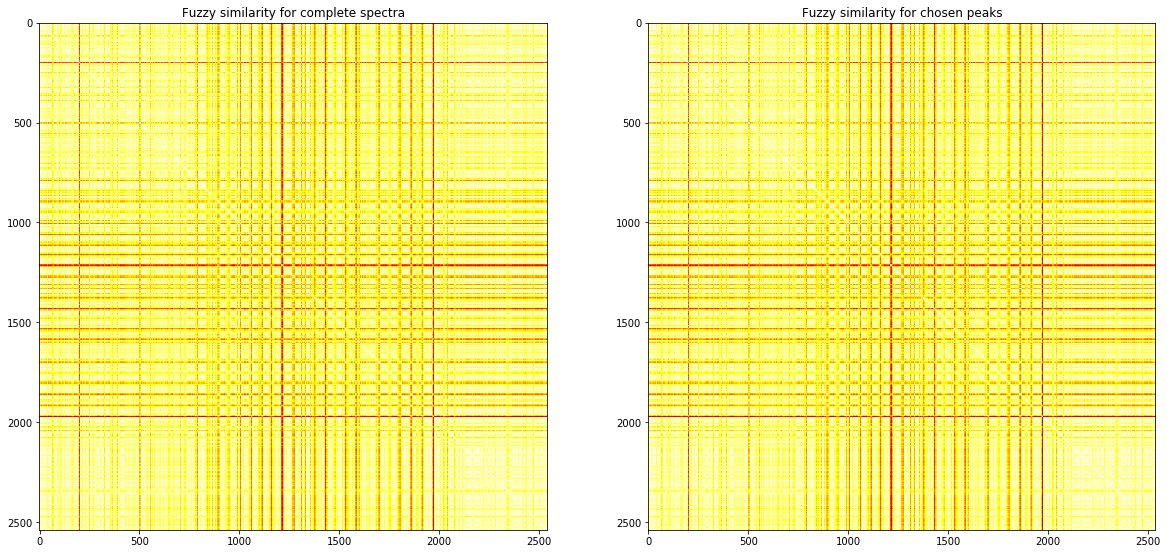

In [8]:
fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
plt.imshow(matrix_similarity_all, cmap='hot', interpolation='nearest')
plt.title('Fuzzy similarity for complete spectra')
fig.add_subplot(1,2,2)
plt.imshow(matrix_similarity_peaks, cmap='hot', interpolation='nearest')
plt.title('Fuzzy similarity for chosen peaks')
plt.show()   

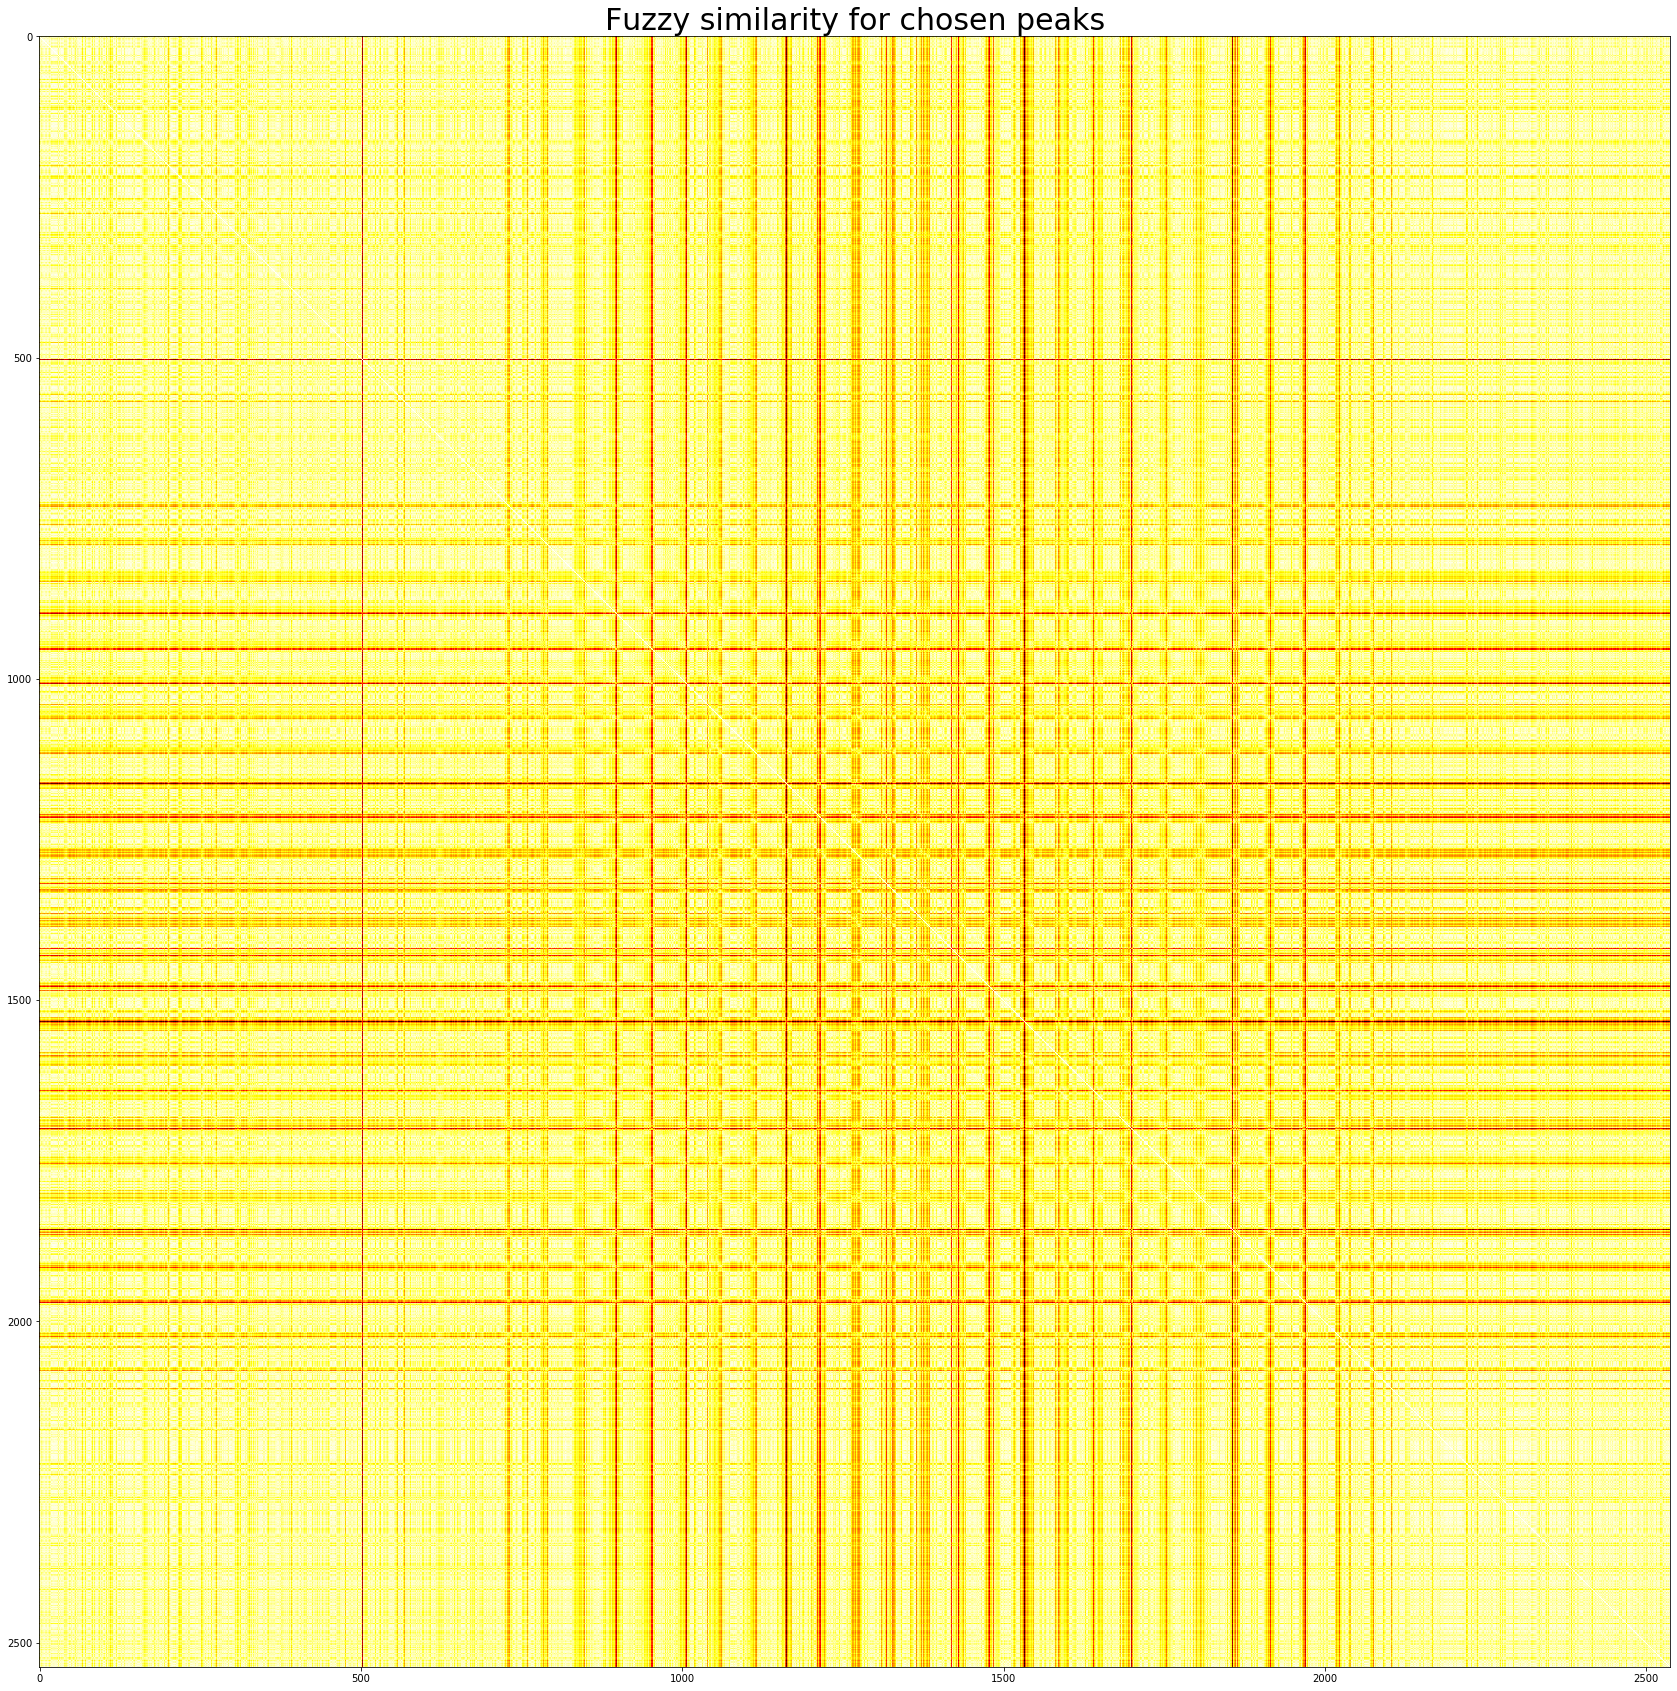

In [9]:
plt.figure(figsize=(30, 30))
plt.imshow(matrix_similarity_all, cmap='hot', interpolation='nearest')
plt.title('Fuzzy similarity for complete spectra', fontsize = 30)
plt.savefig('plots/matrix_all.png')
plt.imshow(matrix_similarity_peaks, cmap='hot', interpolation='nearest')
plt.title('Fuzzy similarity for chosen peaks', fontsize = 30)
plt.savefig('plots/matrix_peaks.png')